In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Revisiting the Source Normalization

A more rigorous approach to comparing the various source normalization curves - meaning those corresponding to each length of storage run - will be pursued here. 

Suppose you normalized based on the average number of counts in all the runs in the entire experiment. Then if there were an energy dependent effect, which we fully expect there to be, the magnitude of this effect would be encapsulated in the calculated average. For the scenario we anticipate, the average counts of the lower storage time measurements would be lower than they should be. When it comes time to scale by the simple:

$$S = \frac{\text{Average shot counts}}{\text{Average }t_s \text{ counts}}$$

then $S$ will be higher than it should be if the energy dependent effect were not present. 



We could define a parameter that is:

$$\Theta = \frac{\Gamma}{N_0}$$

where $\Gamma$ is the fitted loss rate to the nominal configuration data, in neutrons per unit time, and $N_0$ is the number of neutrons present in a run that would have taken place at the beginning of the experiment. This should be a small extrapolation from the existing data.

In [4]:
data_5

array([[1.10918000e+05, 5.00000000e+00, 3.18706587e+06, 9.81924038e+03,
        8.03200000e+00],
       [1.11219000e+05, 5.00000000e+00, 3.17402694e+06, 9.79913354e+03,
        8.03300000e+00],
       [1.11520000e+05, 5.00000000e+00, 3.19487108e+06, 9.83125681e+03,
        8.03400000e+00],
       [1.11820000e+05, 5.00000000e+00, 3.17012433e+06, 9.79310746e+03,
        8.03500000e+00],
       [1.24579000e+05, 5.00000000e+00, 3.14909868e+06, 9.76057734e+03,
        8.07700000e+00],
       [1.24880000e+05, 5.00000000e+00, 3.15236597e+06, 9.76563949e+03,
        8.07800000e+00],
       [1.25180000e+05, 5.00000000e+00, 3.15097435e+06, 9.76348371e+03,
        8.07900000e+00],
       [1.82359000e+05, 5.00000000e+00, 2.84227537e+06, 9.27289726e+03,
        9.12100000e+00],
       [1.82659000e+05, 5.00000000e+00, 2.84203335e+06, 9.27250245e+03,
        9.12200000e+00],
       [1.82960000e+05, 5.00000000e+00, 2.84145854e+06, 9.27156472e+03,
        9.12300000e+00],
       [2.15903000e+05, 5.0000

In [29]:
config = "NORM"

data_5    = load_data_2(config, 's005', normalize_flag = False)
data_20   = load_data_2(config, 's020', normalize_flag = False)
data_100  = load_data_2(config, 's100', normalize_flag = False)
data_shot = load_data_2(config, 'shot', normalize_flag = False)

# data_5[:,2] = data_5[:,2] * np.average(data_shot[:,2]) / np.average(data_5[:,2])
# data_20[:,2] = data_20[:,2] * np.average(data_shot[:,2]) / np.average(data_20[:,2])
# data_100[:,2] = data_100[:,2] * np.average(data_shot[:,2]) / np.average(data_100[:,2])

data_list = [data_5, data_20, data_100, data_shot]

# # A crude normalization for absolute counts

# # 5 second
# norm_factor = (data_list[3][0,2] / np.average(data_list[0][4:7,2]))
# # Multiplying every run's counts by the normalization factor.
# data_list[0][:,2] = data_list[0][:,2] * norm_factor
# data_list[0][:,3] = data_list[0][:,3] * norm_factor

# # 20 second
# norm_factor = (data_list[3][0,2] / np.average(data_list[1][3:6,2]))
# # Multiplying every run's counts by the normalization factor.
# data_list[1][:,2] = data_list[1][:,2] * norm_factor
# data_list[1][:,3] = data_list[1][:,3] * norm_factor

# # 100 second
# norm_factor = (data_list[3][0,2] / np.average(data_list[2][7:13,2]))
# # Multiplying every run's counts by the normalization factor.
# data_list[2][:,2] = data_list[2][:,2] * norm_factor
# data_list[2][:,3] = data_list[2][:,3] * norm_factor

# A more sophisticated re-scaling for absolute counts

# # shot fit parameters calculated
shot_fit_params, pcov = curve_fit(source_fit, data_shot[:,0], data_shot[:,2], p0=[77600, -9], 
                       sigma = data_shot[:,3], absolute_sigma = True)

# plt.scatter(data_shot[:,0], data_shot[:,2])
# plt.plot(data_shot[:,0], source_fit(data_shot[:,0], *popt));
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlabel('Time Elapsed since Experiment Start [s]')
# plt.ylabel('UCN Counts');
# plt.title('Direct Shot - Nominal Config.');

results = np.zeros((4,2))

for i in range(0,4):
    
    # grab the array from the list
    arr = data_list[i]
    
    # perform a fit
    popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], 
                       sigma = arr[:,3], absolute_sigma = True)
    

    # calculate the scale factor, \Theta
    Gamma = popt[1]
    N_0 = popt[0]

    Theta = N_0 / Gamma
    
    results[i,0] = arr[0,1]
    print(shot_fit_params[0])
    print(N_0)
    results[i,1] = Gamma * (shot_fit_params[0] / N_0)
    print(results[i,1])
    
    
    

# print('Fit parameters will be printed in 5, 20, 100, shot order\n')

# ax = plt.gca()
# for arr in data_list:
#     color = next(ax._get_lines.prop_cycler)['color']
#     popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], sigma = arr[:,3], absolute_sigma = True)
    
#     plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', label = '{} s'.format(arr[0,1]), color = color)
#     plt.plot(arr[:,0], source_fit(arr[:,0], *popt), color = color);

#     # printing the fit parameters and their errors:
#     fit_parameters = np.zeros(np.shape(pcov))
#     for i in range(0, np.size(popt)):
#         fit_parameters[i,0] = popt[i]
#         fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
#     print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
#             fit_parameters[0,0],
#             fit_parameters[0,1],
#             fit_parameters[1,0],
#             fit_parameters[1,1]))
    
# plt.legend()
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.xlabel('Time Elapsed since Experiment Start [s]')
# plt.ylabel('UCN Counts in Normalization Runs');
# # plt.yscale('log')

4010821.0936660464
128024.47188558702
-7.547977144649562
4010821.0936660464
67170.8830638719
-7.232042805761742
4010821.0936660464
5273.943712275858
-6.8032471742153735
4010821.0936660464
4010821.0936660464
-8.590787342777054


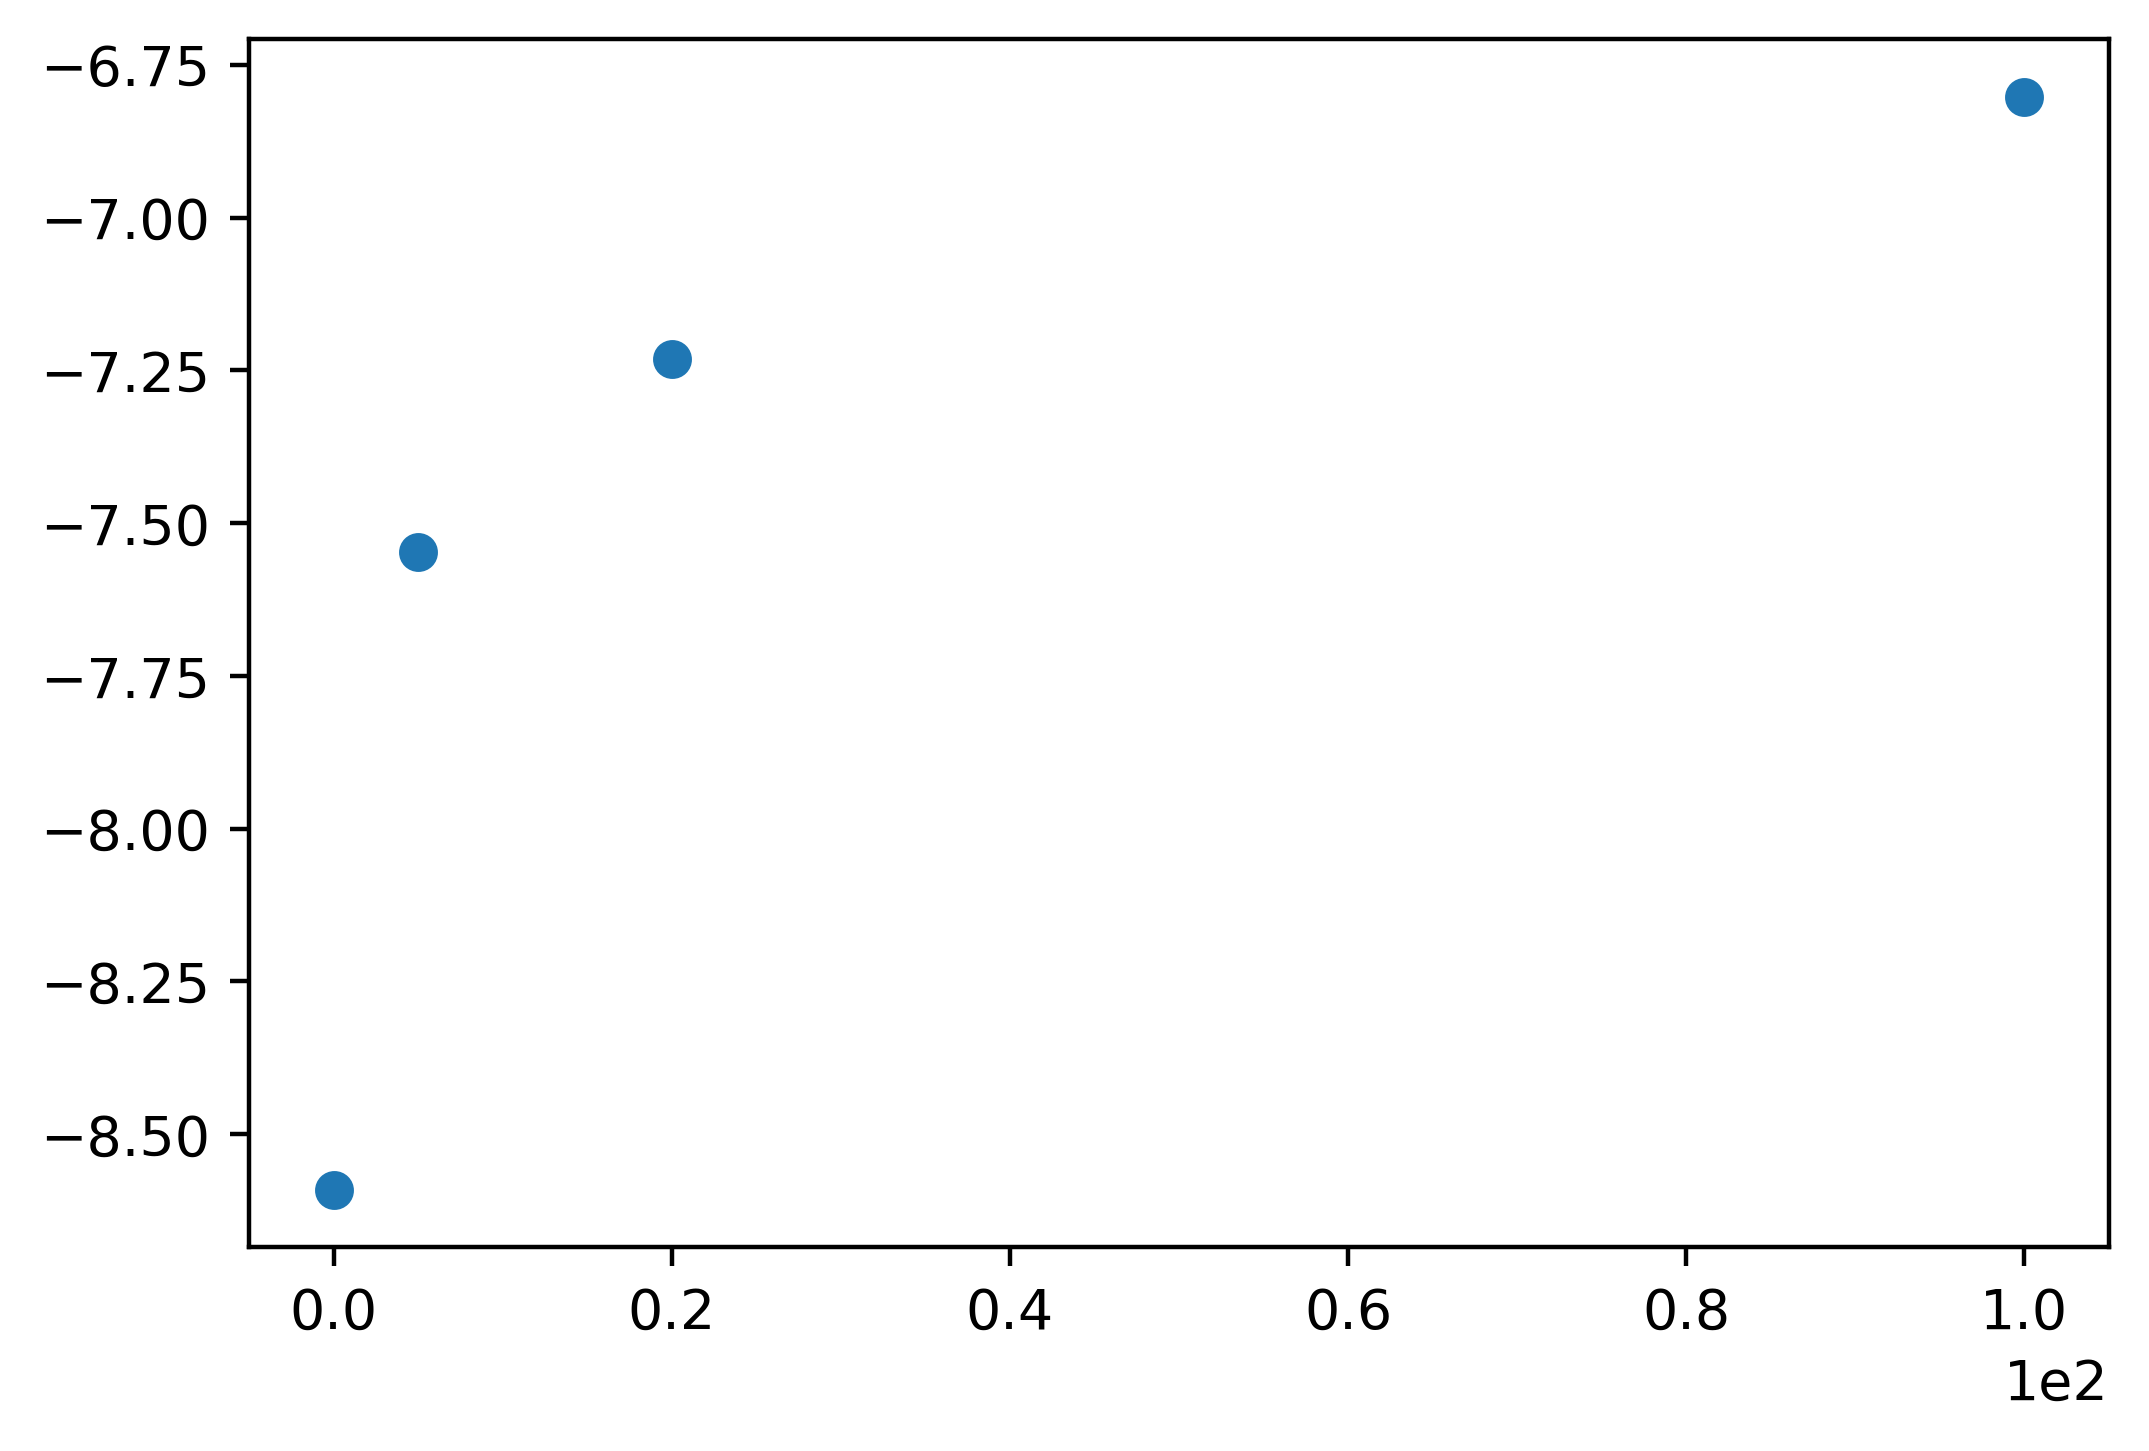

In [28]:
results
plt.scatter(results[:,0], results[:,1])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [20]:
results

array([[ 5.00000000e+00, -1.88190322e-06],
       [ 2.00000000e+01, -1.80313273e-06],
       [ 1.00000000e+02, -1.69622305e-06],
       [ 0.00000000e+00, -2.14190240e-06]])